In [70]:
## Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

## Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions

## 
import odor_stat_calculations as osc
import pandas as pd 
import os
import numpy as np

## scipy gaussian regressor 
import scipy
import scipy.stats as stats
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

## bayesian optimization 
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.axes_grid1 import make_axes_locatable 

from joblib import load, dump

### Using saturation correction over 10 and applying boxcox to the training data and prediction

In [118]:
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
df_train = df[:22000]
df_test = df[22000:]

# df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
# query = 'odor>=2'
# df_extracted = df_train.query(query)
# df_extracted.reset_index(inplace=True, drop=True) 

df_extracted = df_train.copy()

# df_test_extracted = df_test.query(query)
# df_test_extracted.reset_index(inplace=True, drop=True) 

far_distance_threshold = 10 
saturation_threshold = 10 

far_data = df_extracted[df_extracted['distance_along_streakline'] > far_distance_threshold]


##### Sensor Saturation correction 

In [119]:
def fit_exponential_distribution(far_data, threshold):
    non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
    loc, scale = stats.expon.fit(non_saturated_data)
    return loc, scale

loc, scale = fit_exponential_distribution(far_data, saturation_threshold)

def generate_values_above_threshold(loc, scale, threshold, size):
    cdf_threshold = stats.expon.cdf(threshold, loc=loc, scale=scale)
    uniform_values = np.random.uniform(cdf_threshold, 1, size)
    values_above_threshold = stats.expon.ppf(uniform_values, loc=loc, scale=scale)
    return values_above_threshold

def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
    saturated_indices = df[df['odor'] >= threshold].index
    estimated_values = generate_values_above_threshold(loc, scale, threshold, len(saturated_indices))
    df.loc[saturated_indices, 'odor'] = estimated_values
    return df

# Apply the correction
df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)
new_test_df = df_extracted.copy()
new_test_df['corrected_odor'] = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)['odor']

##### Boxcox Transformation

In [73]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', n_quantiles=2000)
df_corrected['odor_transformed'] = qt.fit_transform(df_corrected['odor'].values.reshape(-1, 1)).flatten()
new_test_df['odor_transformed'] = qt.transform(new_test_df['corrected_odor'].values.reshape(-1, 1)).flatten()


(array([   2.,   30.,  394., 2823., 7826., 7592., 2914.,  396.,   20.,
           3.]),
 array([-5.19933758, -4.15947007, -3.11960255, -2.07973503, -1.03986752,
         0.        ,  1.03986752,  2.07973503,  3.11960255,  4.15947007,
         5.19933758]),
 <BarContainer object of 10 artists>)

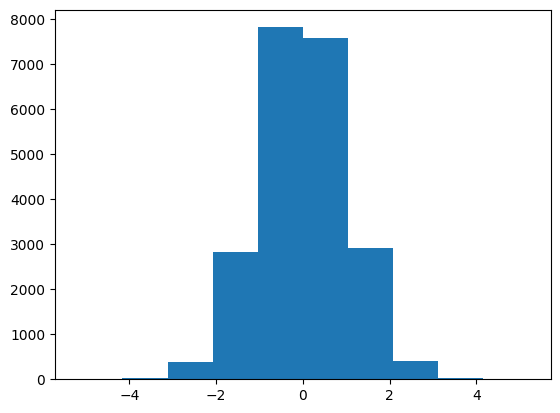

In [74]:
plt.hist(df_corrected.odor_transformed)

In [62]:
def apply_boxcox(data):
    data_min = np.min(data)
    shift = 0 
    if data_min <= 0:
        shift = np.abs(data_min) + 0.5
        data_shifted = data + shift
    else:
        data_shifted = data

    transformed_data, lambda_ = stats.boxcox(data_shifted)

    return transformed_data, lambda_, shift

def inverse_boxcox(transformed_data, lambda_, shift):
    if shift != 0:
        original_data = scipy.special.inv_boxcox(transformed_data, lambda_) - shift
    else:
        original_data = scipy.special.inv_boxcox(transformed_data, lambda_)
    return original_data

# Apply Box-Cox transformation to the corrected training data
df_corrected['odor_transformed'], lambda_, shift = apply_boxcox(df_corrected['odor'])
new_test_df['odor_transformed'] = df_corrected.odor_transformed

##### Train the GPR with Transformed Data

In [43]:
# Training the GPR with transformed data
X = df_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
y_transformed = df_corrected['odor_transformed'].values.reshape(-1, 1)

use_scaler = True  
if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

lengthscale=0.1

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_transformed).flatten()

# Define the kernel for the Gaussian Process Regressor
# kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1)) 
kernel = C(0.814**2, (1e-2, 1e2)) * (RBF(lengthscale, (1e-2, 1e1)) + Matern(length_scale=lengthscale, nu=0.5))
alpha = 0.263

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=alpha)
gp.fit(X_scaled, y_scaled)

trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler
print(gp.kernel_)
print("Spatial Model Training Done")


0.689**2 * RBF(length_scale=0.0415) + Matern(length_scale=0.00489, nu=0.5)
Spatial Model Training Done


In [120]:
# import joblib

# # # Define file paths
# model_file = '../models/gpr_model.pkl'
# scaler_file = '../models/scaler.pkl'
# target_scaler_file = '../models/target_scaler.pkl'

# # Save the Gaussian Process Regressor model
# joblib.dump(trained_model, model_file)

# # Save the input feature scaler
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_file)

# # Save the target variable scaler
# joblib.dump(trained_target_scaler, target_scaler_file)

# print("Model and scalers have been saved successfully.")

# Load the saved model and scalers
trained_model = load('../gpr_model.pkl')
trained_scaler = load('../scaler.pkl')
trained_target_scaler = load('../target_scaler.pkl')

print("Model and scalers have been loaded successfully.")



Model and scalers have been loaded successfully.


#####  Make Predictions with the GPR

In [8]:
# Test the model
new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if trained_scaler is not None:
    new_X_test_scaled = trained_scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = trained_model.predict(new_X_test_scaled, return_std=True)
new_y_pred_mean_transformed = trained_target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()
# new_y_pred_mean_original = inverse_boxcox(new_y_pred_mean_transformed, lambda_, shift)  # Use the lambda_ and shift from training
new_y_pred_mean_original = qt.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()


new_test_df['y_predicted_transformed']=new_y_pred_mean_original
# new_test_df['y_predicted_original'] = new_y_pred_mean_original

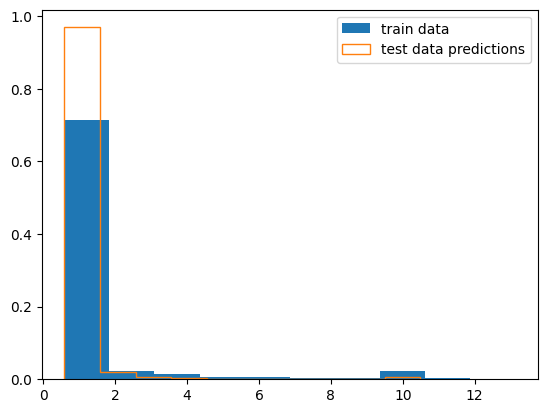

In [9]:
plt.hist(new_test_df.corrected_odor, label = 'train data', density=True)
# plt.hist(new_test_df.odor_transformed, label = 'train data transformed')
plt.hist(new_test_df.y_predicted_transformed, histtype='step', density=True, label='test data predictions')
# plt.hist(new_test_df.y_predicted_original, histtype='step', label='predictions transformed\n using training data $\lambda$')

# plt.xlabel('odor')
# plt.ylabel('count')
plt.legend(loc="best")

In [8]:
# y_true = new_test_df['odor'].values
# iso_reg = IsotonicRegression(out_of_bounds='clip')
# y_pred_calibrated = iso_reg.fit_transform(new_test_df.y_predicted_original, y_true)

# new_test_df['y_predicted_calibrated'] = y_pred_calibrated


(0.0, 100.0)

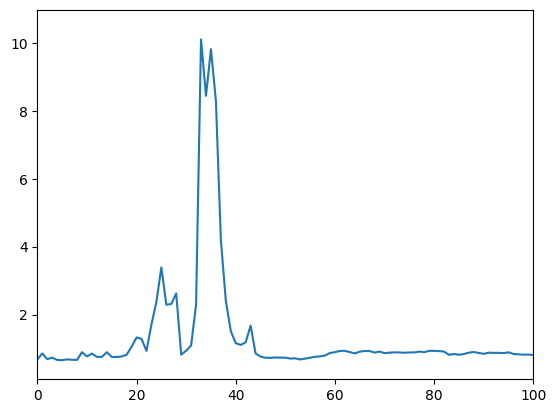

In [10]:
plt.plot(new_test_df.y_predicted_transformed)
plt.xlim(0,100)

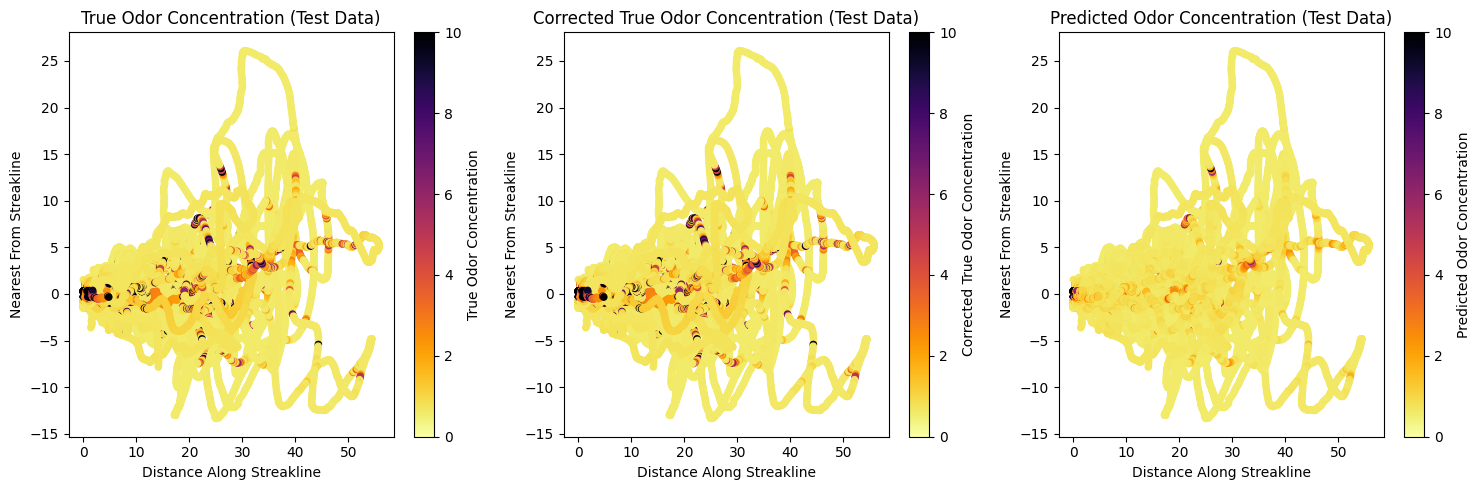

In [11]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['corrected_odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Corrected True Odor Concentration')
plt.title('Corrected True Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 3)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['y_predicted_transformed'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()

##### Apply Inverse Box-Cox Transformation to Predictions

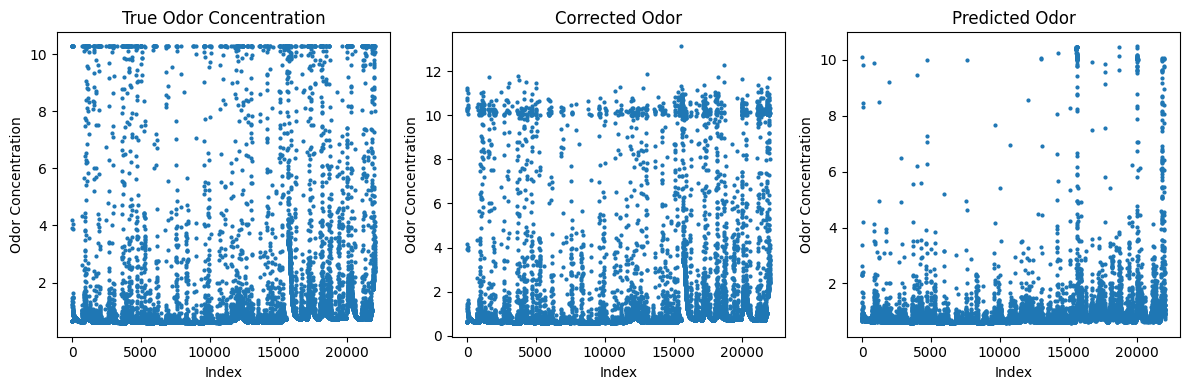

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))  

ax[0].plot(new_test_df.index, new_test_df['odor'], 'o', markersize=2, label='True Odor')
ax[0].set_title('True Odor Concentration')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Odor Concentration')
# ax[0].legend()

ax[1].plot(new_test_df.index, new_test_df['corrected_odor'], 'o', markersize=2,label='Corrected Odor')
ax[1].set_title('Corrected Odor')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Odor Concentration')
# ax[1].legend()


# Plotting the predicted odor
ax[2].plot(new_test_df.index, new_test_df.y_predicted_transformed, 'o', markersize=2, label='Predicted Odor')
ax[2].set_title('Predicted Odor')
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Odor Concentration')
# ax[2].legend()

fig.tight_layout()

In [65]:
# Apply the inverse Box-Cox transformation to the predicted values
# if shift != 0:
#     new_y_pred_mean_original = scipy.special.inv_boxcox(new_y_pred_mean_transformed, lambda_) - shift
# else:
#     new_y_pred_mean_original = scipy.special.inv_boxcox(new_y_pred_mean_transformed, lambda_)

# new_y_pred_mean_original = np.clip(new_y_pred_mean_original, 0, saturation_threshold)
# new_test_df['y_predicted'] = new_y_pred_mean_original



In [135]:
# new_test_df = df_test.query(query)
new_test_df=df_test.copy()
new_test_df.reset_index(inplace=True, drop=True)

# Apply the correction to the test data
new_test_corrected = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)

# Apply Box-Cox transformation to the corrected test data
# new_test_corrected['odor_transformed'], lambda_test, shift_test = apply_boxcox(new_test_corrected['odor'])
# new_test_corrected['odor_transformed'] = qt.transform(new_test_corrected['odor'].values.reshape(-1, 1)).flatten()


# Prepare the test data for prediction
new_X_test = new_test_corrected[['distance_along_streakline', 'nearest_from_streakline']].values

if trained_scaler is not None:
    new_X_test_scaled = trained_scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

# Make predictions with the trained GPR
new_y_pred_mean, new_y_pred_std = trained_model.predict(new_X_test_scaled, return_std=True)
new_y_pred_mean_transformed = trained_target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# Apply the inverse Box-Cox transformation to the predicted values
# new_y_pred_mean_original = inverse_boxcox(new_y_pred_mean_transformed, lambda_test, shift_test)
# new_y_pred_mean_original = qt.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# new_y_pred_mean_original = np.clip(new_y_pred_mean_original, 0, saturation_threshold)
# new_test_df['y_predicted'] = new_y_pred_mean_original
# new_test_df['corrected_odor_before_transform']=new_test_corrected.odor
new_test_df['corrected_odor'] = new_test_corrected.odor
new_test_df['y_predicted']=new_y_pred_mean_transformed

In [111]:
from scipy.stats import norm

def quantile_mapping(predictions, mean_pred, std_pred, mean_train, std_train):
    """
    Adjusts the predicted values to match the distribution of the training data using quantile mapping.

    :param predictions: The predicted values from the model.
    :param mean_pred: Mean of the predicted values' distribution.
    :param std_pred: Standard deviation of the predicted values' distribution.
    :param mean_train: Mean of the training data's distribution.
    :param std_train: Standard deviation of the training data's distribution.
    :return: Adjusted predictions to match the training data distribution.
    """
    # Compute the CDF of the predictions based on the predicted distribution
    quantiles = norm.cdf(predictions, loc=mean_pred, scale=std_pred)
    
    # Use the CDF to determine the corresponding values in the training data distribution
    adjusted_predictions = norm.ppf(quantiles, loc=mean_train, scale=std_train)
    
    return adjusted_predictions


# Fit normal distributions to the train data and predictions
mean_train, std_train = norm.fit(df_corrected['odor'])
mean_pred, std_pred = norm.fit(new_test_df.y_predicted)
# new_y_pred_mean = np.clip(new_y_pred_mean, df_corrected['odor'].min(), df_corrected['odor'].max())
# Apply quantile mapping
adjusted_predictions = quantile_mapping(new_y_pred_mean, mean_pred, std_pred, mean_train, std_train)
new_test_df['adjusted_y_predicted'] = adjusted_predictions

In [124]:
min_val = new_test_df['odor'].min()
max_val = new_test_df['odor'].max()

adjusted_predictions = np.clip(new_test_df.y_predicted, min_val, max_val)
new_test_df['adjusted_y_predicted_clipped'] = adjusted_predictions

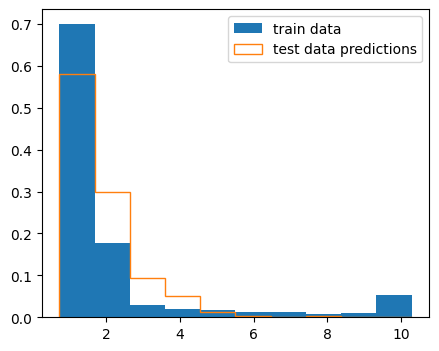

In [125]:
f,ax=plt.subplots(1,1,figsize=(5,4))
ax.hist(new_test_df.odor, density=True, label = 'train data')
# ax.hist(new_test_corrected.odor_transformed, label = 'train data transformed')
# ax.hist(new_y_pred_mean_transformed, label='test data predictions')
ax.hist(new_test_df.adjusted_y_predicted_clipped, density = True, histtype='step', label='test data predictions')

# plt.xlabel('odor')
# plt.ylabel('count')
ax.legend(loc="best")

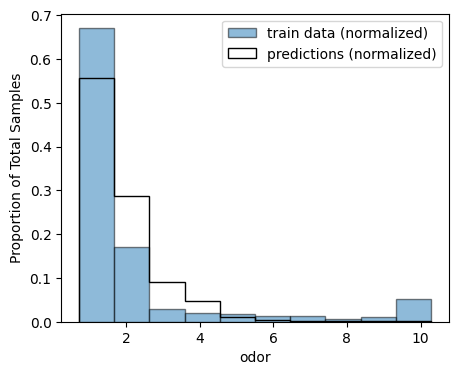

In [127]:
f, ax = plt.subplots(1, 1, figsize=(5, 4))

# Normalize by the number of samples (relative frequency)
train_weights = np.ones_like(new_test_df.odor) / len(new_test_df.odor)
pred_weights = np.ones_like(new_test_df.adjusted_y_predicted_clipped) / len(new_test_df.adjusted_y_predicted_clipped)

# Plot the histograms with weights
ax.hist(new_test_df.odor, bins=10, weights=train_weights, alpha=0.5, edgecolor='black', label='train data (normalized)')
ax.hist(new_test_df.adjusted_y_predicted_clipped, bins=10, weights=pred_weights, histtype='step', label='predictions (normalized)', edgecolor='black')

ax.set_xlabel('odor')
ax.set_ylabel('Proportion of Total Samples')
ax.legend(loc="best")

plt.show()


In [130]:
# from scipy.ndimage import gaussian_filter1d
# new_test_df['y_predicted_smoothed'] = gaussian_filter1d(new_test_df['adjusted_y_predicted_clipped'], sigma=1)

new_test=new_test_df.query('odor>1')
new_test.reset_index(inplace=True, drop=True) 

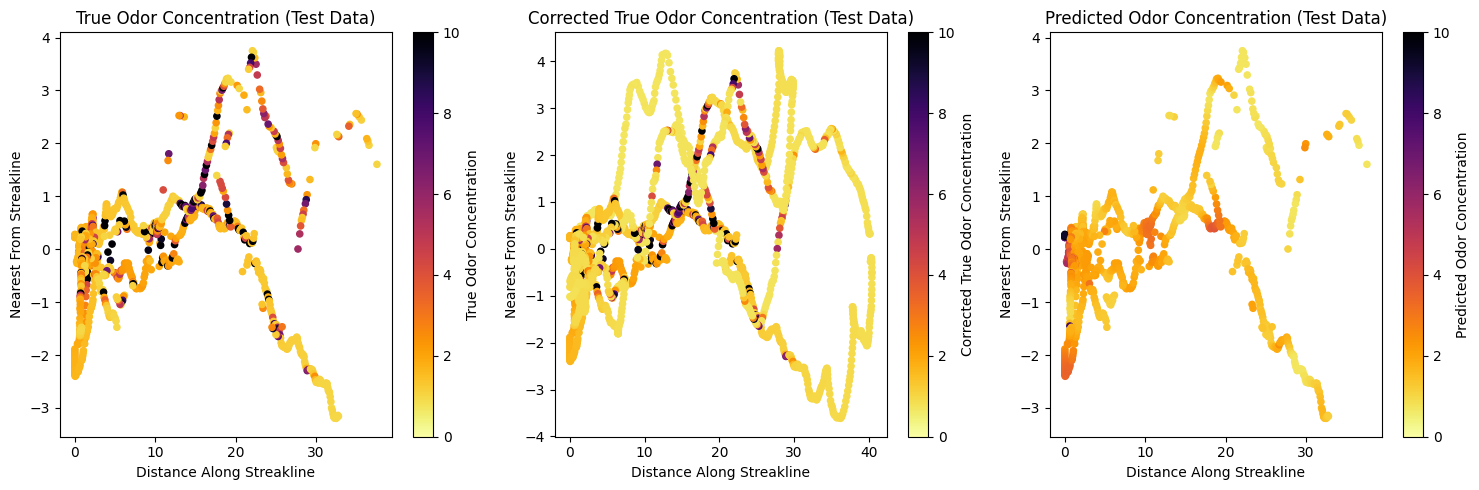

In [131]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(new_test['distance_along_streakline'], new_test['nearest_from_streakline'], c=new_test['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 2)
plt.scatter(new_test_corrected['distance_along_streakline'], new_test_corrected['nearest_from_streakline'], c=new_test_corrected['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Corrected True Odor Concentration')
plt.title('Corrected True Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 3)
plt.scatter(new_test['distance_along_streakline'], new_test['nearest_from_streakline'], c=new_test['adjusted_y_predicted_clipped'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()

In [32]:
# # from sklearn.isotonic import IsotonicRegression

# # y_true = new_test_df['odor'].values
# # iso_reg = IsotonicRegression(out_of_bounds='clip')
# # y_pred_calibrated = iso_reg.fit_transform(new_y_pred_mean_original, y_true)

# from scipy.ndimage import gaussian_filter1d

# # Apply Gaussian smoothing to the predictions
# new_test_df['y_predicted_smoothed'] = gaussian_filter1d(new_test_df['y_predicted'], sigma=1)

# # new_test_df['y_predicted_calibrated'] = y_pred_calibrated

# plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 1)
# plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
# plt.colorbar(label='True Odor Concentration')
# plt.title('True Odor Concentration')
# plt.xlabel('Distance Along Streakline')
# plt.ylabel('Nearest From Streakline')

# plt.subplot(1, 3, 2)
# plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['corrected_odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
# plt.colorbar(label='Corrected True Odor Concentration')
# plt.title('Corrected True Odor Concentration')
# plt.xlabel('Distance Along Streakline')
# plt.ylabel('Nearest From Streakline')

# plt.subplot(1, 3, 3)
# plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df.y_predicted_smoothed, cmap='inferno_r', s=20, vmin=0, vmax=10)
# plt.colorbar(label='Predicted Odor Concentration')
# plt.title('Predicted Odor Concentration')
# plt.xlabel('Distance Along Streakline')
# plt.ylabel('Nearest From Streakline')

# plt.tight_layout()
# plt.show()

In [34]:
# fig, ax = plt.subplots(1,3, figsize=(12, 4))  

# ax[0].plot(new_test_df.index, new_test_df['odor'], 'o', markersize=2, label='True Odor')
# ax[0].set_title('True Odor Concentration')
# ax[0].set_xlabel('Index')
# ax[0].set_ylabel('Odor Concentration')
# # ax[0].legend()

# ax[1].plot(new_test_df.index, new_test_df['corrected_odor'], 'o', markersize=2,label='Corrected Odor')
# ax[1].set_title('Corrected Odor')
# ax[1].set_xlabel('Index')
# ax[1].set_ylabel('Odor Concentration')
# # ax[1].legend()


# # Plotting the predicted odor
# ax[2].plot(new_test_df.index, new_test_df.y_predicted, 'o', markersize=2, label='Predicted Odor')
# ax[2].set_title('Predicted Odor')
# ax[2].set_xlabel('Index')
# ax[2].set_ylabel('Odor Concentration')
# # ax[2].legend()

# fig.tight_layout()

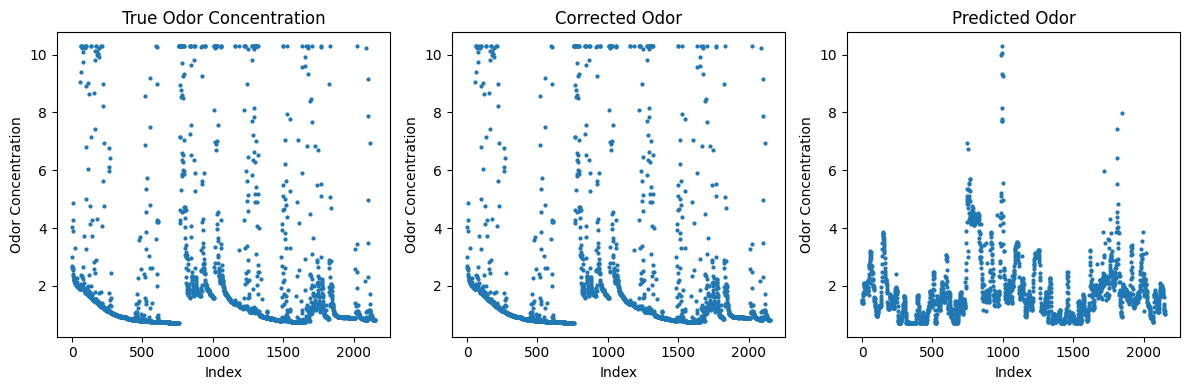

In [134]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))  

ax[0].plot(new_test_df.index, new_test_df['odor'], 'o', markersize=2, label='True Odor')
ax[0].set_title('True Odor Concentration')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Odor Concentration')
# ax[0].legend()

ax[1].plot(new_test_df.index, new_test_df['odor'], 'o', markersize=2,label='Corrected Odor')
ax[1].set_title('Corrected Odor')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Odor Concentration')
# ax[1].legend()


# Plotting the predicted odor
ax[2].plot(new_test_df.index, new_test_df.adjusted_y_predicted_clipped, 'o', markersize=2, label='Predicted Odor')
ax[2].set_title('Predicted Odor')
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Odor Concentration')
# ax[2].legend()

fig.tight_layout()

##### Plotting gridwise histogram

In [85]:
new_test_df['y_predicted']=new_test_df.adjusted_y_predicted_clipped

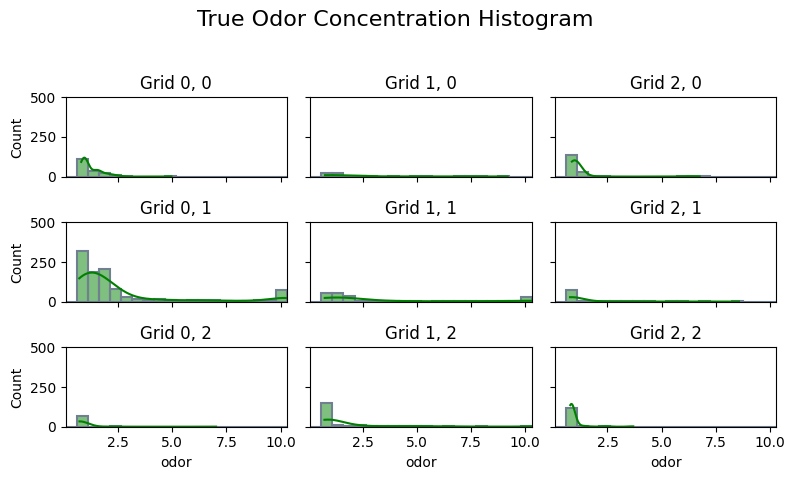

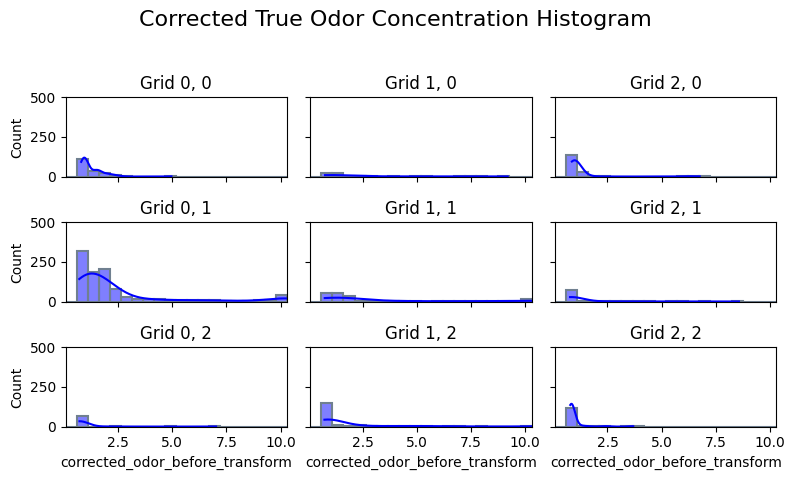

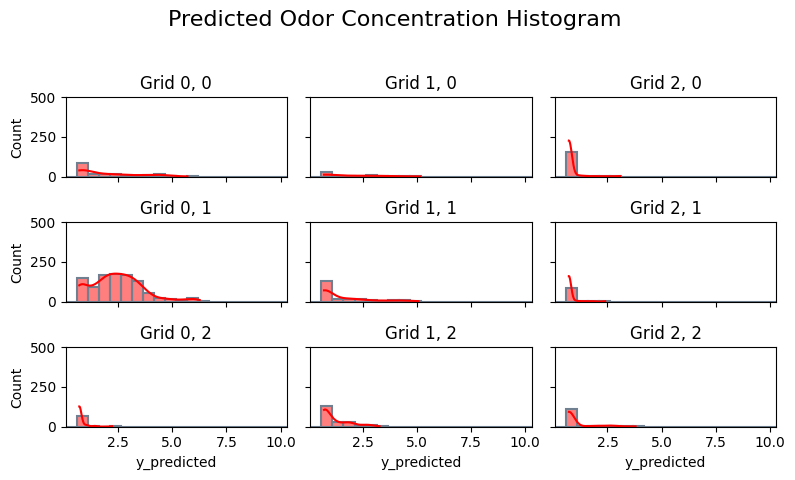

In [86]:
# Define the number of bins for the grid
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'corrected_odor', 'y_predicted']].min().min()
global_max = new_test_df[['odor', 'corrected_odor', 'y_predicted']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limits
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,500]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for corrected true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['corrected_odor_before_transform']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Corrected True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for predicted odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['y_predicted']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='red', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [87]:
def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
# calculate_distance_from_source(x)


In [88]:
new_test_df['predicted_odor'] = new_test_df.y_predicted


In [91]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 1
np.seterr(divide='ignore')
index = osc.get_index(new_test_df.odor,th)
index_predicted = osc.get_index(new_test_df.predicted_odor,th)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df,index,fdf)
cal_stat_predicted(new_test_df,index_predicted, fdf_predicted)

fdf.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.efreq.iloc[start] = 1
/home/gorilla/An/plume_sim/odor_stat_calculations.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

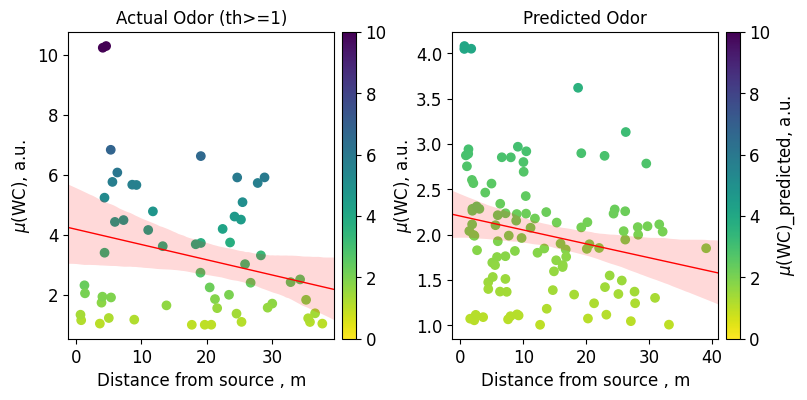

In [92]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var1 = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r', vmin=0,vmax=10 )
ax1.set_ylabel('$\mu$(WC), a.u.')


g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_title('Actual Odor (th>='+str(th)+')')

var2=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10 )
# ax2.set_ylabel('Whiff Concentration, a.u.')


g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

ax2.set_xlabel('Distance from source , m')
# ax2.set_ylabel('$\mu$(WC), a.u.')
ax2.set_title('Predicted Odor')
f.tight_layout(pad=1)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

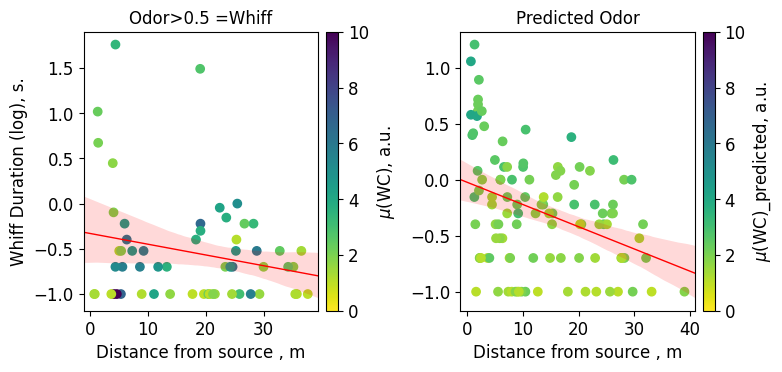

In [93]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis_r',vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)

In [94]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf)
fdf_predicted_new = create_class_column(fdf_predicted)

In [95]:
lookback_time = 5

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_514533/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_514533/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_514533/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_514533/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occu

In [96]:
lookback_time = 5

trainset_predicted= fdf_predicted_new
# trainset= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)

/tmp/ipykernel_514533/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_514533/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_514533/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_514533/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occu

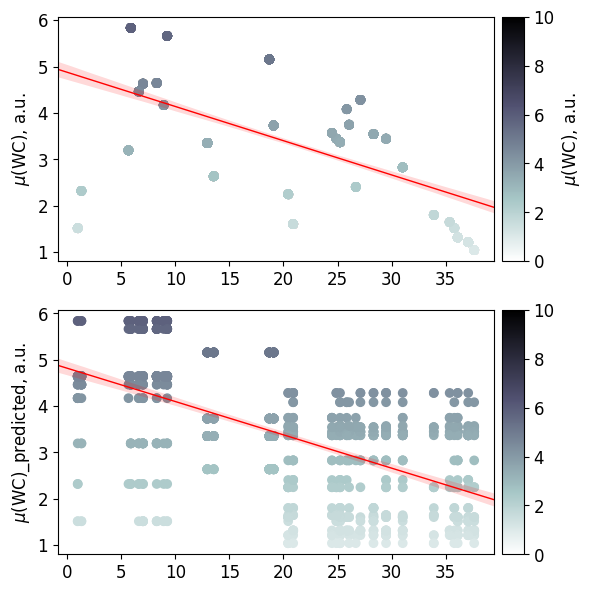

In [97]:
f,ax = plt.subplots(2,1,figsize=(6,6))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)


divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')
ax[0].set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
            ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean, c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
ax[0].set_ylabel('$\mu$(WC), a.u.')
ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)
